## Reinforcement Learning with Python: Deep Deterministic Policy Gradient

Let's solve [Pendulum](https://gym.openai.com/envs/Pendulum-v0/) environment using Deep Deterministic Policy Gradient agent

![LunarLander](../assets/Pendulum_160x160.gif)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import gym

import matplotlib.pyplot as plt
%matplotlib inline

from pyreinforce.brain import Brain
from pyreinforce.acting import OrnsteinUhlenbeckPolicy
from pyreinforce.memory import Memory
from pyreinforce.converter import Converter
from pyreinforce import DdpgAgent

The `Actor` deterministically picks an action for a given state

In [2]:
class Actor(object):
    def __init__(self, sess, n_states, n_hidden, n_actions, lr=None, is_target=False, seed=None):
        super().__init__()

        self._sess = sess

        scope = 'target' if is_target else 'primary'

        with tf.variable_scope('actor'):
            with tf.variable_scope(scope):
                # Input layer
                self._S = tf.placeholder(tf.float32, (None, n_states))

                # Hidden layer
                h1 = tf.layers.dense(self._S, n_hidden, tf.nn.relu, 
                                     kernel_initializer=xavier_initializer(seed=seed), 
                                     trainable=not is_target)

                # Output layer
                self._A = tf.layers.dense(h1, n_actions, tf.nn.tanh, 
                                          kernel_initializer=xavier_initializer(seed=seed), 
                                          trainable=not is_target)

        if not is_target:
            # Backpropagation
            train_vars = tf.trainable_variables('actor/{}'.format(scope))

            self._dQ_dA = tf.placeholder(tf.float32, (None, n_actions))
            grads = tf.gradients(self._A, train_vars, -self._dQ_dA)
            optimizer = tf.train.GradientDescentOptimizer(lr)
            self._train_op = optimizer.apply_gradients(zip(grads, train_vars))            

    def predict_a(self, states):
        if len(states.shape) < len(self._S.shape):
            states = np.expand_dims(states, axis=0)

        return self._sess.run(self._A, {self._S: states})

    def train(self, states, dq_da):
        self._sess.run(self._train_op, {self._S: states, self._dQ_dA: dq_da})

The `Critic` evaluates an action value function estimated by the `Actor`

In [3]:
class Critic(object):
    def __init__(self, sess, n_states, n_hidden, n_actions, lr=None, is_target=False, seed=None):
        super().__init__()

        self._sess = sess

        scope = 'target' if is_target else 'primary'

        with tf.variable_scope('critic'):
            with tf.variable_scope(scope):
                # Input layer
                self._S = tf.placeholder(tf.float32, (None, n_states))
                self._A = tf.placeholder(tf.float32, (None, n_actions))
                X = tf.concat([self._S, self._A], 1)

                # Hidden layer
                h1 = tf.layers.dense(X, n_hidden, tf.nn.relu, 
                                     kernel_initializer=xavier_initializer(seed=seed), 
                                     trainable=not is_target)

                # Output layer
                self._Q = tf.layers.dense(h1, n_actions, 
                                          kernel_initializer=xavier_initializer(seed=seed), 
                                          trainable=not is_target)

        if not is_target:
            self._dQ_dA = tf.gradients(self._Q, self._A)[0]

            # Backpropagation
            self._T = tf.placeholder(tf.float32, (None, n_actions))
            loss = tf.reduce_mean(tf.squared_difference(self._T, self._Q))
            optimizer = tf.train.GradientDescentOptimizer(lr)
            self._train_op = optimizer.minimize(loss)

    def predict_q(self, states, actions):
        if len(states.shape) < len(self._S.shape):
            states = np.expand_dims(states, axis=0)

        if len(actions.shape) < len(self._A.shape):
            actions = np.expand_dims(actions, axis=0)

        return self._sess.run(self._Q, {self._S: states, self._A: actions})

    def dq_da(self, states, actions):
        if len(states.shape) < len(self._S.shape):
            states = np.expand_dims(states, axis=0)

        if len(actions.shape) < len(self._A.shape):
            actions = np.expand_dims(actions, axis=0)

        dq_da = self._sess.run(self._dQ_dA, {self._S: states, self._A: actions})

        return dq_da

    def train(self, states, actions, targets):
        self._sess.run(self._train_op, {self._S: states, self._A: actions, self._T: targets})

The `Brain` manages both the actor and the critic along with their target networks

In [4]:
# Helper function that updates target network's weights/biases
def update_target_network(from_scope, to_scope, tau):
    from_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=from_scope)
    to_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=to_scope)

    ops = [tf.assign(t, (1 - tau) * t + tau * p) for p, t in zip(from_variables, to_variables)]

    return ops


class DdpgBrain(Brain):
    def __init__(self, sess, actor, target_actor, critic, target_critic, tau):
        super().__init__()

        self._sess = sess

        self._actor = actor
        self._target_actor = target_actor
        self._critic = critic
        self._target_critic = target_critic

        update_actor = update_target_network('actor/primary', 'actor/target', tau)
        update_critic = update_target_network('critic/primary', 'critic/target', tau)

        self._update_target_ops = update_actor + update_critic

    def predict_a(self, states, is_target=False, **kwargs):
        brain = self._target_actor if is_target else self._actor

        return brain.predict_a(states)

    def predict_q(self, states, actions, is_target=False, **kwargs):
        brain = self._target_critic if is_target else self._critic

        return brain.predict_q(states, actions)

    def train(self, states, actions, targets, **kwargs):
        self._critic.train(states, actions, targets)

        actions = self.predict_a(states, False)
        dq_da = self._critic.dq_da(states, actions)

        self._actor.train(states, dq_da)

        self._sess.run(self._update_target_ops)

    def __enter__(self):
        self._sess.__enter__()

        init = tf.global_variables_initializer()
        self._sess.run(init)

        return self

    def __exit__(self, *args):
        self._sess.__exit__(*args)

Actions must be pre-processed before being passed to the environment

In [5]:
class PendulumConverter(Converter):
    def convert_action(self, a):
        a = np.clip(a, -1, 1)
        a *= 2

        return a

Training parameters

In [6]:
# Seed
seed = 123

# Brain
n_states = 3
n_hidden = 256
n_actions = 1
lr = 0.001
tau = 0.01

# Action Selection Policy
mu=0.0
theta=0.05
sigma=0.01

# Replay Memory
replay_memory_size = 100000
replay_batch_size = 64

# Agent
n_episodes = 500
gamma = 0.96

Putting it all together

In [9]:
env = gym.make('Pendulum-v0')
env.seed(seed)

tf.reset_default_graph()

sess = tf.Session()

actor = Actor(sess, n_states, n_hidden, n_actions, lr, False, seed)
target_actor = Actor(sess, n_states, n_hidden, n_actions, None, True, seed)
critic = Critic(sess, n_states, n_hidden, n_actions, lr, False, seed)
target_critic = Critic(sess, n_states, n_hidden, n_actions, None, True, seed)
brain = DdpgBrain(sess, actor, target_actor, critic, target_critic, tau)

acting = OrnsteinUhlenbeckPolicy(n_actions, mu, theta, sigma)
replay_memory = Memory(replay_memory_size, replay_batch_size)
converter = PendulumConverter()

agent = DdpgAgent(n_episodes, env, brain, acting, replay_memory, gamma, converter)
agent.seed(seed)

with brain:
    rewards, _ = agent.run()

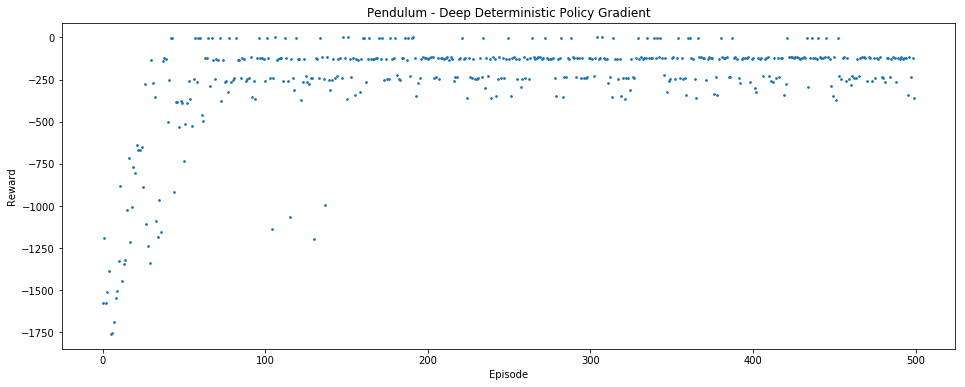

In [10]:
plt.figure(figsize=(16, 6))
plt.title('Pendulum - Deep Deterministic Policy Gradient')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)